In [1]:
import requests
import time
from time import clock
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


s = requests.Session()
r = s.get('https://www.espn.com')


SWID = '#####'
espn_s2 = "#####"


#swid = s.cookies.get_dict()['SWID']
#espn_s2 = s.cookies.get_dict()['espn_s2']

league_id = #####


url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/2019/segments/0/leagues/%s' %league_id

r = requests.get(url, cookies={"swid": SWID, 'espn_s2': espn_s2}).json()

#Get Team IDs
teamId = {}
#print(r)
#print("\n\n##############\n\n")
for team in r['teams']:
    teamId[team['id']] = team['location'].strip() + ' ' + team['nickname'].strip()


#Get each team's weekly points and calculate their head-to-head records
weeklyPoints = {}
r = requests.get(url, cookies={"swid": SWID, 'espn_s2': espn_s2}, params={"view": "mMatchup"}).json()


weeklyPts = pd.DataFrame()
for each in r['schedule']:
    #each = r['schedule'][0]

    week = each['matchupPeriodId']
    if week >= 14:
        continue

    homeTm = teamId[each['home']['teamId']]
    homeTmPts = each['home']['totalPoints']

    try:
        awayTm = teamId[each['away']['teamId']]
        awayTmPts = each['away']['totalPoints']
    except:
        homeTmPts = 'BYE'
        continue

    temp_df = pd.DataFrame(list(zip([homeTm, awayTm], [homeTmPts, awayTmPts], [week, week])), columns=['team','pts','week'])

    if homeTmPts > awayTmPts:
        temp_df.loc[0,'win'] = 1
        temp_df.loc[0,'loss'] = 0
        temp_df.loc[0,'tie'] = 0

        temp_df.loc[1,'win'] = 0
        temp_df.loc[1,'loss'] = 1
        temp_df.loc[1,'tie'] = 0

    elif homeTmPts < awayTmPts:
        temp_df.loc[0,'win'] = 0
        temp_df.loc[0,'loss'] = 1
        temp_df.loc[0,'tie'] = 0

        temp_df.loc[1,'win'] = 1
        temp_df.loc[1,'loss'] = 0
        temp_df.loc[1,'tie'] = 0

    elif homeTmPts == awayTmPts:
        temp_df.loc[0,'win'] = 0
        temp_df.loc[0,'loss'] = 0
        temp_df.loc[0,'tie'] = 1

        temp_df.loc[1,'win'] = 0
        temp_df.loc[1,'loss'] = 0
        temp_df.loc[1,'tie'] = 1

    weeklyPts = weeklyPts.append(temp_df, sort=True).reset_index(drop=True)
#print(temp_df)
#print(weeklyPts)
weeklyPts['win'] = weeklyPts.groupby(['team'])['win'].cumsum()
weeklyPts['loss'] = weeklyPts.groupby(['team'])['loss'].cumsum()
weeklyPts['tie'] = weeklyPts.groupby(['team'])['tie'].cumsum()



# Calculate each teams record compared to all other teams points week to week
cumWeeklyRecord = {}   
for week in weeklyPts[weeklyPts['pts'] > 0]['week'].unique():
    df = weeklyPts[weeklyPts['week'] == week]

    cumWeeklyRecord[week] = {}
    for idx, row in df.iterrows():
        team = row['team']
        pts = row['pts']
        win = len(df[df['pts'] < pts])
        loss = len(df[df['pts'] > pts])
        tie = len(df[df['pts'] == pts])

        cumWeeklyRecord[week][team] = {}
        cumWeeklyRecord[week][team]['win'] = win
        cumWeeklyRecord[week][team]['loss'] = loss
        cumWeeklyRecord[week][team]['tie'] = tie-1

# Combine those cumluative records to get an overall season record      
overallRecord = {}     
for each in cumWeeklyRecord.items():
    for team in each[1].keys():
        #print(each)
        if team not in overallRecord.keys():
            overallRecord[team] = {} 

        win = each[1][team]['win']
        loss = each[1][team]['loss']
        tie = each[1][team]['tie']

        if 'win' not in overallRecord[team].keys():
            overallRecord[team]['win'] = win
        else:
            overallRecord[team]['win'] += win

        if 'loss' not in overallRecord[team].keys():
            overallRecord[team]['loss'] = loss
        else:
            overallRecord[team]['loss'] += loss

        if 'tie' not in overallRecord[team].keys():
            overallRecord[team]['tie'] = tie
        else:
            overallRecord[team]['tie'] += tie


# Little cleaning up of the data nd calculating win %
overallRecord_df = pd.DataFrame(overallRecord).T
overallRecord_df = overallRecord_df.rename_axis('team').reset_index()
overallRecord_df = overallRecord_df.rename(columns={'win':'overall_win', 'loss':'overall_loss','tie':'overall_tie'})
overallRecord_df['overall_win%'] = overallRecord_df['overall_win'] / (overallRecord_df['overall_win'] + overallRecord_df['overall_loss'] + overallRecord_df['overall_tie'])
overallRecord_df['overall_rank'] = overallRecord_df['overall_win%'].rank(ascending=False, method='min')




regularSeasRecord = weeklyPts[weeklyPts['week'] == 13][['team','win','loss', 'tie']]
regularSeasRecord['win%'] = regularSeasRecord['win'] / (regularSeasRecord['win'] + regularSeasRecord['loss'] + regularSeasRecord['tie'])
regularSeasRecord['rank'] = regularSeasRecord['win%'].rank(ascending=False, method='min')



final_df = overallRecord_df.merge(regularSeasRecord, how='left', on=['team'])


SyntaxError: EOL while scanning string literal (<ipython-input-1-896c9fe2735d>, line 14)

9.0

In [6]:
#works to generate all permutations of list for person
def schedule_maker(LIST, LEVEL = 0):
    #return list
    combos = []
    #base case return the list input
    #could make more efficient later if necesseary/wanted I think
    if LEVEL == len(LIST):
        #return string nothing left to change or iterations to make
        return LIST
    #swap points at the level currently being examined
    #swapper should be the same for every loop so init outside of loop
    swapper = LIST[LEVEL]
    for i in range(LEVEL,len(LIST)):
        new_input = LIST[:]
        temp = new_input[i]
        swapper = new_input[LEVEL]
        new_input[i] = swapper
        new_input[LEVEL] = temp
        #combos.append(schedule_maker(new_input, LEVEL+1))
        add = schedule_maker(new_input, LEVEL+1)
        if (LEVEL == len(LIST)-1):
            combos.append(add)
        elif (LEVEL != len(LIST)-1):
            for i in range(len(add)):
                combos.append(add[i])
    return combos

In [8]:
#function returns DataFrame of every schedule and team wins
def sched_wins(team_interest):
    #takes ~80-90mins for a 12 man league
    start = clock()
    result = []

    #make list of opponents
    opponents = list(final_df['team'])
    opponents.remove(team_interest)
    
    #all schedule possibilities
    possibilities = schedule_maker(opponents)
    for poss in possibilities:
        #only have weeks 1-11 need to add 12/13
        #my league repeats weeks 6 and 7 so the 5th and 6th elements with python indexing
        tempy = poss[0:(len(poss))]
        tempy.extend(tempy[5:7])
        #init wins and week
        wins = 0
        week = 1
        #poss is list items so the list of schedule order
        #go through games and determine wins
        #this does not deal with ties
        for specific in poss:
            #locate points for specific in week n
            opp_points = points_df.loc[week, specific]
            #locate points for team of interest (team_interest) in week n
            self_points = points_df.loc[week, team_interest]
            #increase or maintain win total in df for this possibility
            if opp_points < self_points:
                wins += 1
            week += 1
        temp = [poss, wins]
        result.append(temp)

    stop = clock()
    result = pd.DataFrame(result, columns = ['Schedule', 'Wins'])
    result.head()
    print('Function Complete. Time Elapsed (minutes):',(stop-start)/60)
    return result

In [117]:
#takes ~120mins for a 12 man league (at least on my computer it did)
#might want to replace clock() in the future but I am pretty set with using it to this point
start = clock()
result = []


team_interest = '########'
#make list of opponents
opponents = list(final_df['team'])
opponents.remove(team_interest)

#all schedule possibilities
possibilities = schedule_maker(opponents)
i = 0
for poss in possibilities:
    i += 1
    #only have weeks 1-11 need to add 12/13
    #my league repeats weeks 6 and 7 so the 5th and 6th elements with python indexing
    tempy = poss[0:(len(poss))]
    tempy.extend(tempy[5:7])
    #init wins and week
    wins = 0
    week = 1
    #poss is list items so the list of schedule order
    #go through games and determine wins
    #this does not deal with ties
    for specific in tempy:
        #locate points for specific in week n
        opp_points = points_df.loc[week-1, specific]
        #locate points for team of interest (team_interest) in week n
        self_points = points_df.loc[week-1, team_interest]
        #increase or maintain win total in df for this possibility
        if opp_points < self_points:
            wins += 1
        week += 1
    if i%5000000 == 0:
        print('on iteration', i)
    temp = [poss, wins]
    result.append(temp)

stop = clock()
result = pd.DataFrame(result, columns = ['Schedule', 'Wins'])
result.head()
print('Function Complete. Time Elapsed (minutes):',(stop-start)/60)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



on iteration 5000000
on iteration 10000000
on iteration 15000000
on iteration 20000000
on iteration 25000000
on iteration 30000000
on iteration 35000000


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Function Complete. Time Elapsed (minutes): 104.67221263333334


In [25]:
#here we make points_df

#weeklyPts[weeklyPts['pts'] > 0]['week']
weeklyPts
weeklyPts.team.unique()
df_teams = []
df_points = []
for team_up in weeklyPts.team.unique():
    team_points = []
    temp = weeklyPts[weeklyPts.team == team_up]
    for i in range(0,13):
        team_points.append(temp.iloc[i,1])
    df_teams.append(team_up)
    df_points.append(team_points)
points_df = pd.DataFrame( np.transpose(df_points), columns = df_teams)

In [29]:
len(result.Wins)
#check it has the correct humber

39916800

In [2]:
points_df

In [119]:
#make chart of distribution and return 
#probably change this to return the lists necessary for this and the CDF
#could make this a function so it does not have to require manual adjustment
team = team_interest
%matplotlib inline
max_wins = max(result.Wins)
min_wins = min(result.Wins)
print('Team: \t\t' + team)
print('Min Wins: ', min_wins)                   
min_winning_ists = sum(result.Wins == min_wins)
print('Count and Percentage of Schedules resulting in Min Wins: \nCount: \t\t', 
      min_winning_ists, '\nPercentage: \t',
      round(min_winning_ists/len(result.Wins)*100,4),'%')

print('\n')
print('Max Wins: \t', max_wins)
max_winning_ists = sum(result.Wins == max_wins)
print('Count and Percentage of Schedules resulting in Max Wins: \nCount: \t\t', 
      max_winning_ists, '\nPercentage: \t',
      round(max_winning_ists/len(result.Wins)*100,4),'%')


Wins = []
Counts = []
for i in range(1,14):
    temp = result.loc[result.Wins == i]
    Counts.append(len(temp)/len(result.Wins)*100)
    Wins.append(i)

x_pos = [i for i, _ in enumerate(Wins)]




Wins
test = pd.DataFrame([Wins,Counts]).T
test.columns = ['Wins','Perc_Chance']
temp = []
for i in test.Perc_Chance:
    if temp == []:
        temp.append(i)
    else:
        temp.append(i+temp[len(temp)-1])
test['CDF'] = temp

Team: 		Yellowstone Caldera
Min Wins:  2
Count and Percentage of Schedules resulting in Min Wins: 
Count: 		 812 
Percentage: 	 0.002 %


Max Wins: 	 12
Count and Percentage of Schedules resulting in Max Wins: 
Count: 		 76122 
Percentage: 	 0.1907 %


In [ ]:
#making playoffs
#data taken from the random leauge playoff percentage file
playoffs = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [5, 47], 7: [47, 63], 8: [50, 50], 9: [39, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}
byes = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [0, 47], 7: [0, 63], 8: [8, 50], 9: [21, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}
#getting a bye

Team: 		Yellowstone Caldera
Min Wins: 	 2
Count and Percentage of Schedules resulting in Min Wins: 
Count: 		 812 
Percentage: 	 0.002 %


Max Wins: 	 12
Count and Percentage of Schedules resulting in Max Wins: 
Count: 		 76122 
Percentage: 	 0.1907 %


Percent of countcomes predicted to make playoffs: 83.47%
Percent of countcomes predicted to get playoff bye: 32.79%


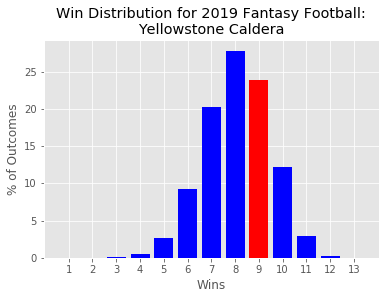

In [121]:
import matplotlib.pyplot as plt 
#change results to be a dict defined in the object
#search for team name in it and have that as results_3
#
team = team_interest
print('Team: \t\t' + team)
print('Min Wins: \t', min_wins)                   
min_winning_ists = sum(result.Wins == min_wins)
print('Count and Percentage of Schedules resulting in Min Wins: \nCount: \t\t', 
      min_winning_ists, '\nPercentage: \t',
      round(min_winning_ists/len(result.Wins)*100,4),'%')

print('\n')
print('Max Wins: \t', max_wins)
max_winning_ists = sum(result.Wins == max_wins)
print('Count and Percentage of Schedules resulting in Max Wins: \nCount: \t\t', 
      max_winning_ists, '\nPercentage: \t',
      round(max_winning_ists/len(result.Wins)*100,4),'%')
plt.style.use('ggplot')

#search for this table which distribution should make
#dict of distribution
#make the y values counts
#x_vals = xpos

print('\n')
temp = [0]
for item in Counts:
    temp.append(item)
predicted_bye_perc = 0
for i in range(len(temp)):
    predicted_bye_perc = predicted_bye_perc + (temp[i]/100)*(bye_percs[i]/100)

temp = [0]
for item in Counts:
    temp.append(item)
predicted_playoff_perc = 0
for i in range(len(temp)):
    predicted_playoff_perc = predicted_playoff_perc + (temp[i]/100)*(playoff_percs[i]/100)

print('Percent of countcomes predicted to make playoffs: ' + str(round(predicted_playoff_perc*10000)/100)+'%')
print('Percent of countcomes predicted to get playoff bye: ' + str(round(predicted_bye_perc*10000)/100) +'%')


plt.style.use('ggplot')


cols = []
for i in range(len(Wins)):
    if (i+1) == final_df.set_index('team').loc[team, 'win']:
        cols.append('red')
    else:
        cols.append('blue')



plt.bar(x_pos, Counts, color=cols)
plt.xlabel("Wins")
plt.ylabel("% of Outcomes")
plt.title("Win Distribution for 2019 Fantasy Football:" + '\n' + team)

plt.xticks(x_pos, Wins)

plt.show()

In [ ]:

temp = [0]
for item in Counts:
    temp.append(item)
predicted_bye_perc = 0
for i in range(len(temp)):
    predicted_bye_perc = predicted_bye_perc + (temp[i]/100)*(bye_percs[i]/100)
print(predicted_bye_perc)


temp = [0]
for item in Counts:
    temp.append(item)
predicted_playoff_perc = 0
for i in range(len(temp)):
    predicted_playoff_perc = predicted_playoff_perc + (temp[i]/100)*(playoff_percs[i]/100)
print(predicted_playoff_perc)

In [72]:
print(Counts)
print(bye_percs)
temp

[0.0009419592752926086, 0.04942279942279943, 0.6724987974987975, 4.186688311688312, 14.249098124098126, 27.967231842231843, 30.97661135161135, 17.5261544011544, 4.126503126503127, 0.24484928651595317, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 0, 0, 36, 67, 100, 100, 100, 100]


[0,
 0.0009419592752926086,
 0.04942279942279943,
 0.6724987974987975,
 4.186688311688312,
 14.249098124098126,
 27.967231842231843,
 30.97661135161135,
 17.5261544011544,
 4.126503126503127,
 0.24484928651595317,
 0.0,
 0.0,
 0.0]

In [49]:
#making playoffs
playoffs = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [5, 47], 7: [47, 63], 8: [50, 50], 9: [39, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}
byes = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [0, 47], 7: [0, 63], 8: [8, 50], 9: [21, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}
#getting a bye


In [80]:

final_df.drop(columns = 'team')

,overall_loss,overall_tie,overall_win,overall_win%,overall_rank,win,loss,tie,win%,rank
0,55,0,88,0.615385,4.0,6.0,7.0,0.0,0.461538,7.0
1,85,0,58,0.405594,10.0,6.0,7.0,0.0,0.461538,7.0
2,114,0,29,0.202797,12.0,3.0,10.0,0.0,0.230769,11.0
3,70,0,73,0.510490,6.0,5.0,8.0,0.0,0.384615,10.0
4,76,0,67,0.468531,8.0,7.0,6.0,0.0,0.538462,4.0
5,61,0,82,0.573427,5.0,7.0,6.0,0.0,0.538462,4.0
6,76,0,67,0.468531,8.0,6.0,7.0,0.0,0.461538,7.0
7,44,0,99,0.692308,1.0,9.0,4.0,0.0,0.692308,2.0
8,54,0,89,0.622378,3.0,9.0,4.0,0.0,0.692308,2.0
9,48,0,95,0.664336,2.0,7.0,6.0,0.0,0.538462,4.0


In [84]:
playoffs = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [5, 47], 7: [47, 63], 8: [50, 50], 9: [39, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}
byes = {0: [0, 0], 1: [0, 5], 2: [0, 11], 3: [0, 21], 4: [0, 32], 5: [0, 41], 6: [0, 47], 7: [0, 63], 8: [8, 50], 9: [21, 39], 10: [15, 15], 11: [10, 10], 12: [2, 2], 13: [0, 0]}


In [85]:
winny = []
for i in range(0,14):
    winny.append(i)
bye_percs = []
playoff_percs = []
for i in range(0,14):
    if i == 0:
        playoff_percs.append(0)
        bye_percs.append(0)
    elif i == 13:
        playoff_percs.append(100)
        bye_percs.append(100)
    else:
        playoff_percs.append(round(playoffs[i][0]/playoffs[i][1]*100))
        bye_percs.append(round(byes[i][0]/byes[i][1]*100))


In [86]:
temp = [0]
for item in Counts:
    temp.append(item)
predicted_bye_perc = 0
for i in range(len(temp)):
    predicted_bye_perc = predicted_bye_perc + (temp[i]/100)*(bye_percs[i]/100)

temp = [0]
for item in Counts:
    temp.append(item)
predicted_playoff_perc = 0
for i in range(len(temp)):
    predicted_playoff_perc = predicted_playoff_perc + (temp[i]/100)*(playoff_percs[i]/100)

print('Percent of countcomes predicted to make playoffs: ' + str(round(predicted_playoff_perc*10000)/100)+'%')
print('Percent of countcomes predicted to get playoff bye: ' + str(round(predicted_bye_perc*10000)/100) +'%')


Percent of countcomes predicted to make playoffs: 48.21%
Percent of countcomes predicted to get playoff bye: 5.28%


In [83]:
temp = [0]
for item in Counts:
    temp.append(item)
predicted_bye_perc = 0
for i in range(len(temp)):
    predicted_bye_perc = predicted_bye_perc + (temp[i]/100)*(bye_percs[i]/100)
print(predicted_bye_perc)


temp = [0]
for item in Counts:
    temp.append(item)
predicted_playoff_perc = 0
for i in range(len(temp)):
    predicted_playoff_perc = predicted_playoff_perc + (temp[i]/100)*(playoff_percs[i]/100)
print(predicted_playoff_perc)

0.09319021965688633
0.5952606621773289


In [3]:
#could look at specific results to see what schedules would be msot favorable
result.loc[result.Wins == 10,:].iloc[0,0]

In [124]:
sum(result.Wins)/len(result.Wins)/13
#checking that all play record has the same $ as the mean sim, final_df printed two cells below

0.6223776223776224

In [108]:

dict_ = {}
for item in result.Schedule:
    if i in dict_.keys():
        dict_[i] += 1
    else:
        dict_[i] = 1
max(dict_.values())

39916800

In [4]:
sfinal_df